# Recommended Parameter Analysis 

# TODO plot examples:
* basic sample run as close to historical ETH price in SCDa - eth_price, market_price (in eith), redemption rate (target_rate) - Historical or generated? models/market_model/data/debt_market_df.csv for historical
* Shock test plot
* Grid viz
* Sensativity 
* Data frame of all runs - number of monte carlos, frequency of success on multi metrics - Large battery of experiments against true/false KPIs


## How to run an experiment


# Todo
* Provide glossary of terms at the top of notebooks
* Simple new notebooks. Don't refactor Ben's add a supported folder
* “legible” notebooks we want
    * Single sample run (sanity checks / demos)
    * variation of the above with monte carlo runs
    * limited example explaining shock tests (different from the scripts that actually run large batteries of shock tests)
    * limited example explaining the grid searches (different from the scripts that actually run the cartesian products of params)
    * limited example explaining the sensitivity tests (different from the scripts that actually run the more exhaustive sensitivity tests)
* note that these limited example notebooks should be using data from the those larger experiments but not trying to plot it. it would be relevant to include summary statistics in a table for the larger experiments but the schema for theses tables — each record is an experiments configuration (feature vector is the simulation params) and the facts are the metrics assigned to those runs in post processing (effectively labels in ML parlance)
* Pick some parameters, run experiment, pick 4-5 plots to see what happened. (Look at dashboard for which plots)
* https://stats.reflexer.finance/
* 'eth_price' == generated eth_price
* eth_locked  == eth_locked
* RAI_balance == outstanding rai - total principal liabilities 
* target_rate == redemption rate
* target_price == redemption price
* market_price', 'market_price_twap',
* eth_collateral_value', 'collateralization_ratio


## Overview

As the result of an exhaustive parameter sweep search outline [here](https://hackmd.io/pDc6UM9tSiCZUjoEv7GMNQ?both), the recommended parameters data set is analyzed in this notebook in order to aid intuition around the recommended parameters. 

### Metrics for assessment

1. **Volatility** threshold of market price: defined as the maximum value for the **standard deviation** computed. Defined relative to ETH price volatility. Definition: ratio of RAI price volatility / ETH price volatility is not to exceed 0.5.
  - over simulation period;
  - as moving average with 10-day window.

2. **Stability** threshold of system: defined as the maximum value for relative frequency of simulation runs that are unstable. Unstable is measured as fraction of runs where:
  - market price runs to infinity/zero (e.g. upper bound 10xPI; lower bound 0.10xPI if initial price is PI);
  - redemption price runs to infinity/zero (e.g. upper bound 10xPI; lower bound 0.10xPI if initial price is PI);
  - Uniswap liquidity (RAI reserve) runs to zero;
  - CDP position (total ETH collateral) runs to infinity/zero.

3. **Liquidity** threshold of secondary market: defined as the maximum slippage value below which the controller is allowed to operate.
:::warning
  - Threshold value will be determined by experimental outcomes, e.g. sample mean of the Monte Carlo outcomes of the slippage value when the system becomes unstable. Would like variance/std deviation of the Monte Carlo slippage series to be small (tight estimate), but can report both mean and variance as part of recommendations 
::: 

4. **Responsiveness** of system: scenario based. Responsiveness would stress-test control parameter values that were selected based upon (1)-(3) above. Scenarios here include:
    - Creating a constant ETH price and then creating a single large shock;
    - Having zero liquidity changes and then creating a single large shock (swap or add/remove).
  KPIs would then be: average amount of time system returns to stability following shock; average amount of time arbitrageur reacts to shock.
  
  

### Parameters swept:
| cadCAD Parameter | Description | Value or Range |
|-----------|-------------|----------------|
| controller_enabled | True: PID controller is on, False: PID Controller is off | [True, False] |
| kp     | Proportional controller term | [1e-20,1e-15,1e-10,1e-5,<br />0.1,0,-0.1,-1e-5,-1e-10,<br />-1e-15,-1e-20] |
| ki     | Integral controller term | [1e-20,1e-15,1e-10,1e-5,<br />0.1,0,-0.1,-1e-5,-1e-10,<br />-1e-15,-1e-20] |
| alpha | Anti-windup/leaky integral term | [999998857063901981428416512] |
| control_ period | Period controller acts | [3600 * 3] |
| enable_ controller_time | Timestep (hourly) at which to enable controller | [7 * 24 * 3600] |
| liquidation_ ratio | Collateralization minimum | [1.45, 1.5] |
| interest_ rate | Gross interest rate | [1, 1.03] |
| debt_ ceiling | CDP subsystem maximum RAI drawn | [1e09] |
| arbitrageur_ considers_ liquidation_ ratio | Whether optimal agg arb price condition is enabled | [True, False] |
| rescale_ target_ price | True: set point is redemption price x liquidation ratio, False: set point is redemption price | [True, False] |
| liquidity_ demand_ enabled | True: Uniswap liquidity demand noise is enabled; False: disabled | [True, False] |
| liquidity_ demand_ max_ percentage | When enabled, maximum value of noise allowed as fraction of RAI Uniswap reserve (discarded if less) | [0.10] |
| liquidity_ demand_ shock_ percentage | When enabled, maximum value of noise applied as fraction of RAI Uniswap reserve (set to maximum if greater) | [0.50] |
| liquidity_ demand_ shock | True = use liquidity_ demand_ shock_ percentage, False = use liquidity_ demand_ max_ percentage |  [True, False] |
| swap | swap = 1: liquidity noise is a swap, swap = 0: liquidity noise is add/remove liquidity | [random.randint(0, 1)] |
| direction | direction = 1: liquidity noise is an addition to RAI reserve, direction = 0: liquidity noise is a subtraction | [random.randint(0, 1)] |
| shock time | Number of weeks after controller is switched on to apply shock | [3 weeks] |
| step height | Height of step function shock as fraction of initial value | [0.3, 0.5] |
  
  
# TODO
Number of experiments = product of the length of the lists x number of monte carlo runs (5) 

154,880 = 2x11x11x1x1x1x2x2x1x2x2x2x1x1x2x1x1x1x2 x 5 MC runs

In [1]:
# import libraries
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [16]:
# meta information

data = {'Number_of_experiments': [154880],'Number_of_monte_carlo_runs': [5],
        'Frequency_of_success':[]}
meta_info = pd.DataFrame.from_dict(data)
meta_info

,Number_of_experiments,Number_of_monte_carlo_runs
0,154880,5


In [2]:
parameter_df = pd.read_pickle("saved_results/processed_results.pickle")

In [3]:
parameter_df.head()

,timedelta,cumulative_time,timestamp,eth_price,liquidity_demand,liquidity_demand_mean,eth_collateral,eth_locked,eth_freed,principal_debt,...,ki,kp,alpha,liquidation_ratio,controller_enabled,control_period,liquidity_demand_shock,arbitrageur_considers_liquidation_ratio,rescale_target_price,target_price_scaled
0,0,0,2017-01-01 00:00:00,294.069151,1.000000,1.000000,154827.528922,154827.528922,0.000000,1.000000e+07,...,-5.000000e-09,2.000000e-07,9.990000e+26,1.45,True,14400.0,False,True,True,4.553
1,3600,3600,2017-01-01 01:00:00,291.208252,906.674484,453.837242,154827.528922,154827.528922,0.000000,1.450000e+07,...,-5.000000e-09,2.000000e-07,9.990000e+26,1.45,True,14400.0,False,True,True,3.140
2,3600,7200,2017-01-01 02:00:00,292.287792,-326.024615,63.906314,107503.536596,154827.528922,47323.992326,9.970037e+06,...,-5.000000e-09,2.000000e-07,9.990000e+26,1.45,True,14400.0,False,True,True,3.140
3,3600,10800,2017-01-01 03:00:00,289.343698,209.658450,136.782382,107503.536596,154827.528922,47323.992326,1.000700e+07,...,-5.000000e-09,2.000000e-07,9.990000e+26,1.45,True,14400.0,False,True,True,3.140
4,3600,14400,2017-01-01 04:00:00,286.827771,-79.844839,28.468771,107503.536596,154827.528922,47323.992326,9.906201e+06,...,-5.000000e-09,2.000000e-07,9.990000e+26,1.45,True,14400.0,False,True,True,3.140


### Understand the structure of the dataset

In [4]:
parameter_df.columns

Index(['timedelta', 'cumulative_time', 'timestamp', 'eth_price',
       'liquidity_demand', 'liquidity_demand_mean', 'eth_collateral',
       'eth_locked', 'eth_freed', 'principal_debt', 'rai_drawn', 'rai_wiped',
       'system_revenue', 'stability_fee', 'market_price', 'market_price_twap',
       'target_price', 'target_rate', 'eth_return', 'eth_gross_return',
       'expected_market_price', 'expected_debt_price', 'error_star',
       'error_star_integral', 'market_slippage', 'RAI_balance', 'ETH_balance',
       'UNI_supply', 'simulation', 'subset', 'run', 'substep', 'timestep',
       'eth_collateral_value', 'collateralization_ratio', 'ki', 'kp', 'alpha',
       'liquidation_ratio', 'controller_enabled', 'control_period',
       'liquidity_demand_shock', 'arbitrageur_considers_liquidation_ratio',
       'rescale_target_price', 'target_price_scaled'],
      dtype='object')

In [5]:
parameter_df.run.unique()

array([1, 2, 3, 4, 5])

In [6]:
parameter_df.subset.unique()

array([0, 1, 2, 3, 4, 5])

In [7]:
parameter_df.substep.unique()

array([ 0, 18])

In [8]:
last_run = parameter_df.query('run==5')

<AxesSubplot:xlabel='timestamp', ylabel='eth_price'>

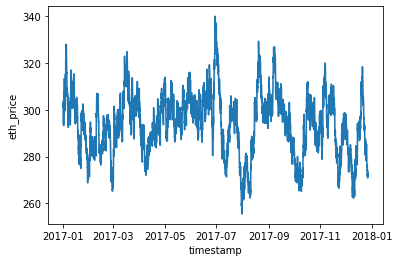

In [9]:
# generated data
sns.lineplot(data=last_run, x="timestamp", y="eth_price")

<AxesSubplot:xlabel='timestamp', ylabel='market_price'>

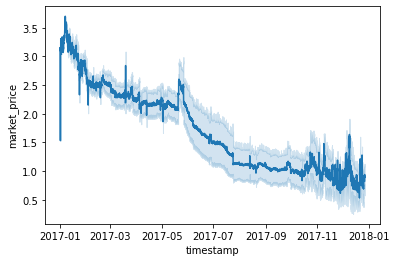

In [10]:
sns.lineplot(data=last_run, x="timestamp", y="market_price")

<AxesSubplot:xlabel='timestamp', ylabel='target_price'>

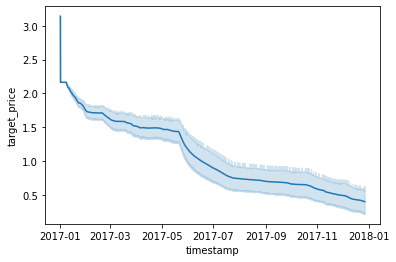

In [17]:
sns.lineplot(data=last_run, x="timestamp", y="target_price")

<AxesSubplot:xlabel='timestamp', ylabel='target_rate'>

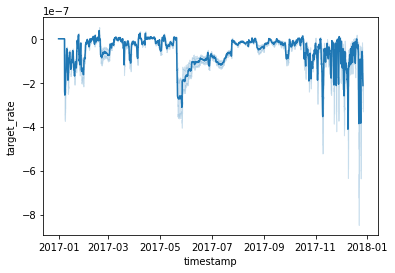

In [11]:
sns.lineplot(data=last_run, x="timestamp", y="target_rate")